### Importing Libraries

In [6]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import Model

from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Lambda

from tensorflow.keras.initializers import TruncatedNormal

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, Callback

from tensorflow.keras.models import load_model

from tensorflow.keras.utils import Sequence


2.8.0-dev20211119


In [17]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

import os

### Defining Shape

In [18]:
NUM_TRAIN = 840
IMAGE_SIZE = (229, 229)
BATCH_SIZE = 64
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

### Reading data

In [19]:
train_directory = '/Users/musubimanagement/Desktop/African_American/train'
train_files = []
for root, directories, files in os.walk(train_directory):
    for file in files:
        train_files.append(os.path.join(root, file))
print(len(train_files))


841


In [20]:
test_directory = '/Users/musubimanagement/Desktop/African_American/test'
test_files = []
for root, directories, files in os.walk(test_directory):
    for file in files:
        test_files.append(os.path.join(root, file))
print(len(test_files))

189


In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory = train_directory,
                                                     labels = 'inferred',
                                                     label_mode = 'binary',
                                                     image_size = IMAGE_SIZE,
                                                     shuffle = True,
                                                     batch_size = BATCH_SIZE)
classes = train_ds.class_names
train_ds = train_ds.prefetch(1)

test_ds = tf.keras.utils.image_dataset_from_directory(directory = test_directory,
                                                    labels = 'inferred',
                                                    label_mode = 'binary',
                                                    image_size = IMAGE_SIZE,
                                                    batch_size = BATCH_SIZE)\
                        .prefetch(1)

Found 840 files belonging to 2 classes.


2021-11-21 01:55:12.473969: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 188 files belonging to 2 classes.


### Sequential Model

In [23]:
AUGMENT_LAYER = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

### Displaying American and African Elephants

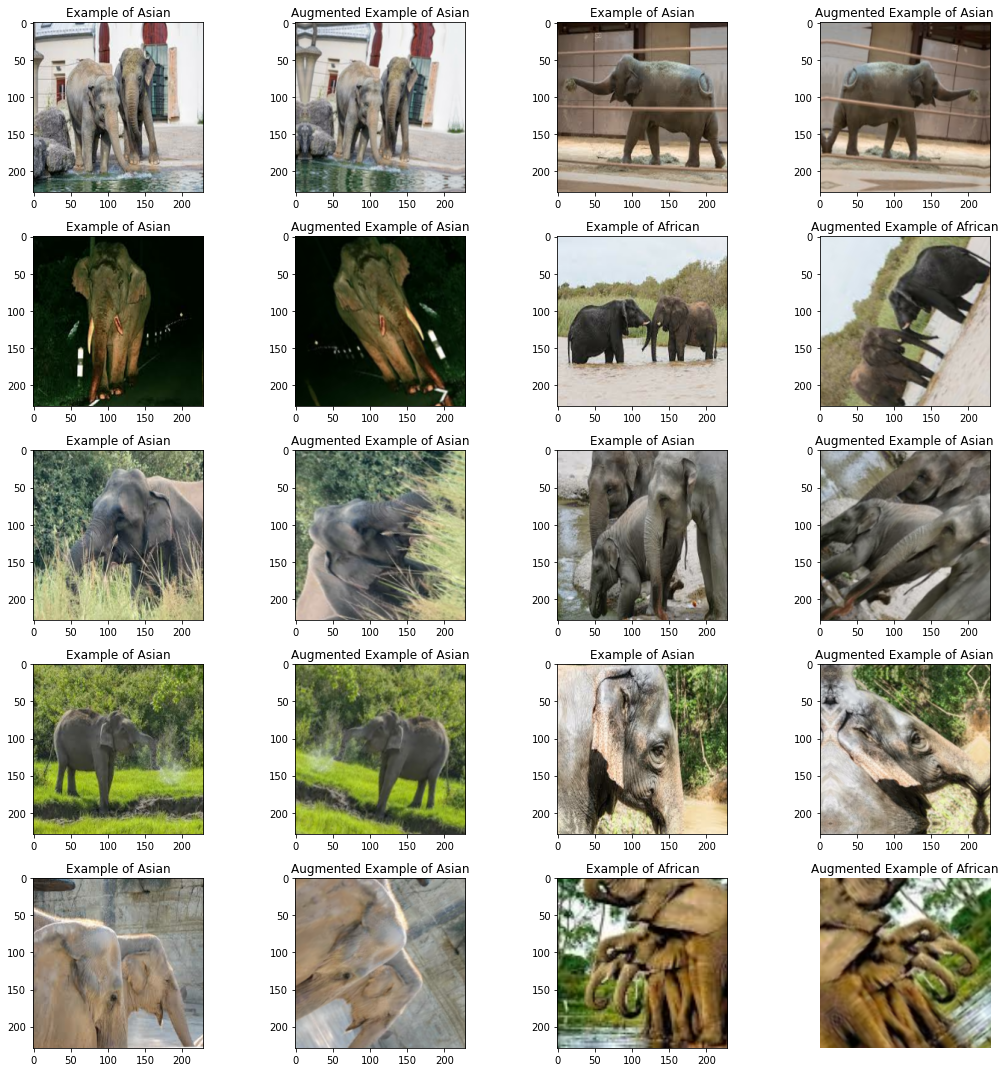

In [24]:
fig, axes = plt.subplots(5, 4, figsize = (15, 15))
axes = axes.flatten()
images_to_show = next(iter(train_ds))
for i in range(10):
    img = images_to_show[0]
    img = img[i] / 255
    lbl = images_to_show[1]
    lbl = lbl.numpy().astype(int).reshape(-1)
    lbl = lbl[i]
    lbl = classes[lbl]
    aug_img = AUGMENT_LAYER(img)
    axes[2 * i].imshow(img)
    axes[2 * i + 1].imshow(aug_img)
    axes[2 * i].set_title(f'Example of {lbl}')
    axes[2 * i + 1].set_title(f'Augmented Example of {lbl}')
    plt.axis('off')
    
plt.tight_layout()

### Building Model

In [25]:
def build_model():
    inp = Input(shape = (*IMAGE_SIZE, 3))
    x = inp
    x = AUGMENT_LAYER(x)
    base_model = InceptionV3(weights = 'imagenet',
                            include_top = False,
                            input_tensor = x)
    
    head_model = base_model.output
    head_model = Flatten()(head_model)
    head_model = Dropout(rate = 0.50)(head_model)
    head_model = Dense(units = 128, activation = 'relu')(head_model)
    
    head_model = Dense(units = 1, activation = 'sigmoid')(head_model)
    
    #inp = base_model.input
    return Model(inputs = inp, outputs = head_model)

In [26]:
model = build_model()

model.compile(optimizer = Adam(learning_rate = 6*10**-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(train_ds, validation_data = test_ds, epochs = 50, callbacks = [early_stopping])

87924736/87910968 [==============================] - 52s 1us/step
Epoch 1/50
14/14 [==============================] - 429s 30s/step - loss: 0.7974 - accuracy: 0.5429 - val_loss: 0.7119 - val_accuracy: 0.5372
Epoch 2/50
14/14 [==============================] - 17236s 1324s/step - loss: 0.6969 - accuracy: 0.5738 - val_loss: 0.6655 - val_accuracy: 0.5957
Epoch 3/50
14/14 [==============================] - 282s 20s/step - loss: 0.6381 - accuracy: 0.6452 - val_loss: 0.7140 - val_accuracy: 0.5851
Epoch 4/50
14/14 [==============================] - 284s 20s/step - loss: 0.6052 - accuracy: 0.6774 - val_loss: 0.5820 - val_accuracy: 0.6862
Epoch 5/50
14/14 [==============================] - 269s 19s/step - loss: 0.5807 - accuracy: 0.7083 - val_loss: 0.4926 - val_accuracy: 0.7500
Epoch 6/50
14/14 [==============================] - 263s 19s/step - loss: 0.5311 - accuracy: 0.7512 - val_loss: 0.4161 - val_accuracy: 0.8191
Epoch 7/50
14/14 [==============================] - 271s 19s/step - loss: 0.49

2021-11-21 14:10:21.245953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 57 of 512
2021-11-21 14:10:21.274719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 58 of 512
2021-11-21 14:10:21.274735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 59 of 512
2021-11-21 14:10:21.274744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 60 of 512
2021-11-21 14:10:21.274756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 61 of 512
2021-11-21 14:10:21.317865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 62 of 512
2021-11-21 14:10:21.317907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this 

14/14 [==============================] - 2728s 208s/step - loss: 0.2377 - accuracy: 0.9083 - val_loss: 0.3960 - val_accuracy: 0.8351
Epoch 28/50
14/14 [==============================] - 15441s 1186s/step - loss: 0.2133 - accuracy: 0.9083 - val_loss: 0.4534 - val_accuracy: 0.8245
Epoch 29/50
14/14 [==============================] - 419s 29s/step - loss: 0.2072 - accuracy: 0.9060 - val_loss: 0.4333 - val_accuracy: 0.8138


### Displaying results on graphs

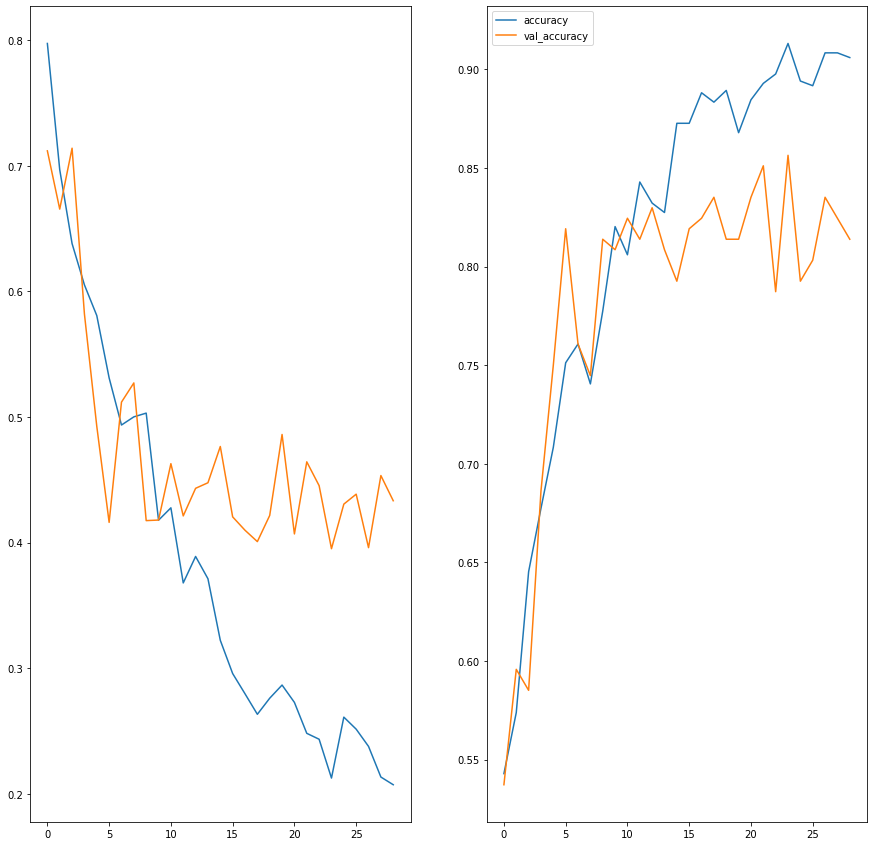

In [44]:
fig, axes = plt.subplots(1, 2, figsize = (15, 15))
axes = axes.flatten()
hist.history.keys()
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(len(loss))
axes[0].plot(epochs, loss, label = 'loss')
axes[0].plot(epochs, val_loss, label = 'val_loss')
axes[1].plot(epochs, acc, label = 'accuracy')
axes[1].plot(epochs, val_acc, label = 'val_accuracy')
plt.legend()


### Model Accuracy

In [42]:
print('Accuracy :',round(max(acc)*100,2),'%')

Accuracy : 91.31 %
